##### Imports

In [1]:
import sys
from pathlib import Path
import warnings

import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

import sys
# Custom library paths
sys.path.extend(['../', './scr'])

from scr.utils import set_seed
from scr.utils import read_words
from pathlib import Path
import random
from collections import Counter, defaultdict
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset

from scr.utils import read_words, save_words_to_file

import pickle
from pathlib import Path
from scr.dataset import *
from scr.utils import *
# # For inference
from scr.feature_engineering import *

import gc

set_seed(42)

import torch
import torch.nn as nn
from pathlib import Path
import random

from scr.utils import print_scenarios
torch.set_float32_matmul_precision('medium')
from pathlib import Path

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Read and Shuffle Word List
word_list = read_words('data/words_250000_train.txt') # , limit=10000)
# word_list = read_words('data/250k.txt', limit=10000)

random.shuffle(word_list)

# Calculate Frequencies and Max Word Length
word_frequencies = calculate_word_frequencies(word_list)
char_frequency = calculate_char_frequencies(word_list)
max_word_length = max(len(word) for word in word_list)

##### Data Dir

In [2]:
NUM_STRATIFIED_SAMPLES = 1_00 # This will be overwritten by Papermill

NUM_WORD_SAMPLE = 20_000 # words for testing

FAST_DEV_RUN = False

MAX_EPOCH = 25

In [3]:
from pathlib import Path

# Define the base directory and the paths for training and validation parquet files
base_dataset_dir = Path("/media/sayem/510B93E12554BBD1/dataset/")
stratified_samples_dir = base_dataset_dir / str(NUM_STRATIFIED_SAMPLES)
parquet_train_path = stratified_samples_dir / 'train_parquets'
parquet_valid_path = stratified_samples_dir / 'valid_parquets'

# Create directories for train and validation parquets if they don't exist
parquet_train_path.mkdir(parents=True, exist_ok=True)
parquet_valid_path.mkdir(parents=True, exist_ok=True)

# Define and create the directory for models
models_dir = Path("/home/sayem/Desktop/Hangman/models")
models_dir.mkdir(parents=True, exist_ok=True)

# Define your output directory
# Define your output directory and logger directory
output_dir = Path("/home/sayem/Desktop/Hangman/training_outputs")
logger_dir = output_dir / "lightning_logs"

# Create the output and logger directories if they don't exist
output_dir.mkdir(parents=True, exist_ok=True)
logger_dir.mkdir(parents=True, exist_ok=True)

# Define the file path for saving the testing words
testing_words_file_path = stratified_samples_dir / "testing_words.txt"

try:
    testing_word_list = read_words(testing_words_file_path)
    print(f"Length of the testing word list: {len(testing_word_list)}")
    sampled_test_words = sample_words(testing_word_list, NUM_WORD_SAMPLE)
    print(f"Sampled {len(sampled_test_words)} unique words for testing.")
except FileNotFoundError:
    print(f"File not found: {testing_words_file_path}")

print(len(sampled_test_words))

Length of the testing word list: 10048
Sampled 10048 unique words for testing.
10048


##### Dataset Loading

In [4]:
# Create datasets directly from the saved parquet files
train_dataset = HangmanDataset(parquet_train_path)
valid_dataset = HangmanDataset(parquet_valid_path)

print(len(train_dataset))
print(len(valid_dataset))

assert len(train_dataset) > len(valid_dataset)

6894
1764


##### Model Initialization

In [5]:
# Usage
from scr.encoder import *
from scr.trainer_ import *
from scr.decoder import SimpleLSTM

# Fixed parameters
max_word_length = 29  # Maximum word length
num_embeddings = 28   # Vocabulary size (fixed, based on unique characters in the game)
num_features = 5      # Number of features per character (could be considered tunable) -> not tunable
missed_char_dim = 28  
output_dim = 28

# Tunable hyperparameters in uppercase
LEARNING_RATE = 1e-5
HIDDEN_DIM = 256
NUM_LAYERS = 3
EMBEDDING_DIM = 50

# Initialize the Encoder
encoder = Encoder(num_embeddings=num_embeddings, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_features=num_features)

# Calculate the input dimension for the LSTM (SimpleLSTM decoder)
input_dim = max_word_length * EMBEDDING_DIM \
    + (num_features - 1) * max_word_length

# Initialize the SimpleLSTM decoder
decoder = SimpleLSTM(input_dim=input_dim, 
                     hidden_dim=HIDDEN_DIM, 
                     output_dim=output_dim, 
                     num_layers=NUM_LAYERS,
                     missed_char_dim=missed_char_dim)  # Using the fixed parameter

In [6]:
# Initialize the HangmanModel
lightning_model = HangmanModel(encoder, decoder, 
                    LEARNING_RATE, char_frequency, 
                    max_word_length, test_words=sampled_test_words)

# Save the model's state dictionary
untrained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_untrained_model.pth"
torch.save(lightning_model, untrained_model_file)
print(f"Model saved at {untrained_model_file}")

Model saved at /home/sayem/Desktop/Hangman/models/100_untrained_model.pth


##### Eval Untrain Model for Initial Performence

In [7]:
# # Load the entire LSTM model object
# untrained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"

untrained_model = torch.load(untrained_model_file)

# Example usage
result = play_games_and_calculate_stats(untrained_model, \
    sampled_test_words, char_frequency, max_word_length)

print(f"Untrained model performence: {result['overall_win_rate']} % win rate")

performance_metrics = result['length_wise_stats']

# print(performance_metrics)

Processing words:   0%|          | 0/10048 [00:00<?, ?word/s]

Untrained model performence: 0.0696656050955414 % win rate


##### Data Module

In [8]:
from scr.data_module import *

# Initialize Data Module
initial_batch_size = 128  # Set your initial batch size

# Initialize Data Module with the required arguments
data_module = HangmanDataModule(train_dataset, valid_dataset, 
                                initial_batch_size, 
                                custom_collate_fn, 
                                performance_metrics=performance_metrics, 
                                threshold_win_rate=50)

##### Testing on Untrained Model

In [9]:
from pytorch_lightning.profilers import SimpleProfiler
import pytorch_lightning as pl
from scr.custom_callbacks import *
from scr.dataset import *
from scr.data_module import *
from scr.trainer_ import *

# # Create Callbacks
# loss_logging_callback = LossLoggingCallback()

callbacks = [early_stop_callback] # , SchedulerSetupCallback()] # , loss_logging_callback]

# FAST_DEV_RUN = False
# # Calculate the minimum percentage of validation batches
# min_val_batches = 1 / len(data_module.val_dataloader())

# # Create Trainer with Callbacks
trainer = pl.Trainer(
    default_root_dir=output_dir,
    fast_dev_run=FAST_DEV_RUN, 
    max_epochs=MAX_EPOCH, 
    callbacks=callbacks,
    num_sanity_val_steps=0,
    # limit_train_batches=2,  # Limit the number of training batches to 2
    # limit_val_batches=2     # Limit the number of validation batches to 2
)

# # # print(f"Running for {NUM_STRATIFIED_SAMPLES} samples...")
# print()
# # # # # # # # # Validate the model (if needed)
# # trainer.validate(model=lightning_model, datamodule=data_module)
# print(f"Training Begin for {NUM_STRATIFIED_SAMPLES} words: {len(train_dataset)} Games")
# # # # # # # Fit the model
# trainer.fit(lightning_model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


##### Tuning: lr

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Processing words:   0%|          | 0/10048 [00:00<?, ?word/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Processing words:   0%|          | 0/10048 [00:00<?, ?word/s]

Processing words:   0%|          | 0/10048 [00:00<?, ?word/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.5754399373371567
Restoring states from the checkpoint path at /home/sayem/Desktop/Hangman/training_outputs/.lr_find_859bf2bb-ba2e-4523-9395-986f5ced015d.ckpt
Restored all states from the checkpoint at /home/sayem/Desktop/Hangman/training_outputs/.lr_find_859bf2bb-ba2e-4523-9395-986f5ced015d.ckpt


Suggested Learning Rate: 0.5754399373371567
{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05

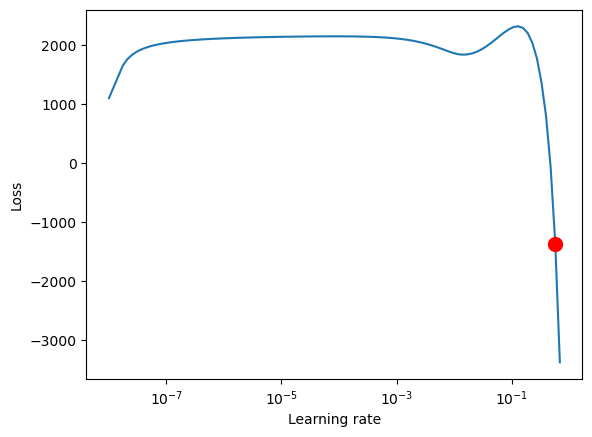

In [10]:
from pytorch_lightning.tuner.tuning import Tuner

# Assuming lightning_model, train_loader, and val_loader are already defined
# Initialize the tuner with your trainer
tuner = Tuner(trainer)

# Run the learning rate finder using the data module
lr_finder = tuner.lr_find(model=lightning_model, datamodule=data_module)

# Plot the learning rate finder results
fig = lr_finder.plot(suggest=True)
fig.show()

# Get the suggested learning rate
new_lr = lr_finder.suggestion()
print(f"Suggested Learning Rate: {new_lr}")

# Update model's learning rate
lightning_model.learning_rate = new_lr

# Optionally, you can view the results of the LR finder
print(lr_finder.results)

##### Tuning: Batch

In [11]:
# Assuming lightning_model is already defined
new_batch_size = tuner.scale_batch_size(
    model=lightning_model,
    datamodule=data_module,
    mode='power',  # or 'binsearch'
    steps_per_trial=10,
    init_val=32,
    max_trials=4
)

# Update the batch size in the data module
data_module.batch_size = new_batch_size

print(f"Tune Batch size: ", new_batch_size)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Processing words:   0%|          | 0/10048 [00:00<?, ?word/s]

##### Training

In [ ]:
# # # # # Validate the model (if needed)
# trainer.validate(model=lightning_model, datamodule=data_module)
print(f"Training Begin for {NUM_STRATIFIED_SAMPLES} words: {len(train_dataset)} Games")
# # # # # # Fit the model
trainer.fit(lightning_model, data_module)

# # Optionally print the profiler summary
# # print(profiler.summary())

# Save the entire model
trained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
torch.save(lightning_model, trained_model_file)
print(f"Model saved at {trained_model_file}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 1.4 K 
1 | decoder | SimpleLSTM | 6.9 M 
---------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.737    Total estimated model params size (MB)


Training Begin for 100 words: 6894 Games


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1000 [00:00<?, ?word/s]

Metric test_win_rate improved. New best score: 13.000


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1000 [00:00<?, ?word/s]

Metric test_win_rate improved by 2.600 >= min_delta = 0.0. New best score: 15.600


Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.datamodule.train_dataloader().batch_size

##### Testing

In [ ]:
trained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
trained_model = torch.load(trained_model_file_path)
print(type(trained_model))

In [ ]:
# Load the entire LSTM model object

trained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
trained_model = torch.load(trained_model_file_path)

# # If you want to use the model for inference
# trained_model.eval()  # Set the model to evaluation mode

from scr.game import *

word = 'may'

play_game_with_a_word(trained_model, \
    word, char_frequency, max_word_length)

In [ ]:
NUM_STRATIFIED_SAMPLES

In [ ]:
# Example usage
result = play_games_and_calculate_stats(trained_model, \
    sampled_test_words, char_frequency, max_word_length)

print(f"Overall Win Rate: {result['overall_win_rate']}%, Overall Average Attempts: {result['overall_avg_attempts']}")

for length, data in result["length_wise_stats"].items():
    print(f"Length {length}: Win Rate: {data['win_rate']}%, Average Attempts: {data['average_attempts_used']}")

In [ ]:
# # Load the entire LSTM model object
# untrained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
untrained_model = torch.load(untrained_model_file)

# # If you want to use the model for inference
# trained_model.eval()  # Set the model to evaluation mode

from scr.game import *

word = 'may'

play_game_with_a_word(untrained_model, \
    word, char_frequency, max_word_length)

# Example usage
result = play_games_and_calculate_stats(untrained_model, \
    sampled_test_words, char_frequency, max_word_length)

print(f"Overall Win Rate: {result['overall_win_rate']}%, Overall Average Attempts: {result['overall_avg_attempts']}")

for length, data in result["length_wise_stats"].items():
    print(f"Length {length}: Win Rate: {data['win_rate']}%, Average Attempts: {data['average_attempts_used']}")